# Practical: Mountain building and Source to Sink in Fastscape

Objectives: 
- To study how uplift changes mountain height and shape 
- To illustrate how changes in bedrock erodbility and climate affect the steady state height and shape of mountains
- To understand the how mountains respond to changes in external conditions (climate,uplift)
- To study how sediment flux and topography interact in source to sink systems

In this practical several lines of code are missing. The text or the comments in the code fields usually tell you where to enter code and what functions to use. Open the P_Fastscape_key notebook to see the solutions.
\
**Throughout the text there are several questions. Write down the answers to the questions into the notebook. We will discuss them later in the practical.**

In [1]:
from fastscape.models import basic_model

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from ipyfastscape import TopoViz3d

%load_ext xsimlab.ipython

## Model
We have imported the Fastscape landscape evolution model. Fastscape models the evolution of a landscape by applying a set of boundary conditions and input variables (initial topography, uplift rate, bedrock erodbility, climate) and then computes the effect of certain landscape processes (hillslope erosion, river erosion, sediment deposition). The final output is elevation at every time step. Other parameters such as erosion rate can also be computed. This allows us to analyse how landcapes evolve under all sorts of conditions and test hypotheses
.
To run a model, we need to define a grid to run on, initial conditions, and which processes we want to include in the model

Let's start below by defining a grid size:

In [2]:
nx,ny = 401,201         # number of grid nodes
xl,yl = 20e3,10e3       # length of model in x and y direction

Of course the more nodes, the higher the resolution of the final model, but the longer it will also take to run.

Now that we have a geometry, let's define time in the model. For that we need to decide on the total time for the model to run as well as the number of time steps. 

In [3]:
tf = 5e6         # model time in years
nstep = 101      # number of time steps
nout = 21        # number of time steps for which we want to print output
tstep = xr.DataArray(np.linspace(0,tf,nstep),dims='tstep')   # make array of time steps
time= xr.DataArray(np.linspace(0,tf,nout),dims='time')

## Creating an input dataset
With these basic parameters, we can now create an input dataset. Here we will create an input dataset `ds_in` that contains all the necessary input parameters for the model, the timing information (as a set of clocks) and information about the output parameters that we wish to save. To help us in this process, a jupyter-notebook extension exists that will scan the model characteristics and create the python code that creates the input dataset:
\
%create_setup model -v -d\
We must include the name of the model as well as a few flags. -v is for verbose and -d for the use of default values of the input parameters (if they exist)\
On completion, this command creates the python code and comments itself out, as seen in the next cell.\
\
**Q1**: Study the input parameters. Which do you understand and which not? What are boundary conditions in a model? Fastscape offers options such as fixed_value, looped, and core. What could that mean?\
\
“core” (open boundary): \
“fixed_value” (closed boundary): \
“looped” (periodic boundary): \
\
SPL stands for stream power incision law and is the main physical law the we use to model erosion due to rivers. We'll learn more about the specific parameters in the SPL next session.

In [4]:
# %create_setup model -v -d
import xsimlab as xs

ds_in = xs.create_setup(
    model=basic_model,
    clocks={'time':time, 'tstep':tstep},
    master_clock = 'tstep',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny,nx],
        # total grid length in (y, x)
        'grid__length': [yl,xl],
        # node status at borders
        'boundary__status': 'fixed_value',
        # uplift rate
        'uplift__rate': 1e-4,
        # random seed
        'init_topography__seed': None,
        # bedrock channel incision coefficient
        'spl__k_coef': 1e-5,
        # drainage area exponent
        'spl__area_exp': 0.45,
        # slope exponent
        'spl__slope_exp': 1,
        # diffusivity
        'diffusion__diffusivity': 3e-2
    },
    output_vars={'topography__elevation':'time',
                 'topography__elevation':'time',
                 'erosion__rate':'time'}
)

We completed the input by adding the values of the various parameters:

- we defined two clocks (`time` and `tstep`) and state that the main (or master) clock is `tstep`
the grid shape is set to `nx`, `ny` and the model size to `xl`, `yl`; note that the coordinates are always specified in the order 𝑦 (vertical) first, 𝑥 (horizontal) 
- boundary conditions; four values can be given that correspond to the left, right, bottom and top boundaries; three options are possible fixed_value for base level boundary condition, core for reflective of zero gradient, and looped for cyclic boundary conditions. Note that a single value (and it must be `fixed_value`) can be given implying that it is applied to all four boundaries
- the uplift rate, and the three parameters of the SPL are given scalar values
- the seed parameter is used to generate a random field for the initial topography; if None is specified, a different initial topography is generated every time the model is run
- we define a set of output variables, namely `topography__elevation`, `drainage__area` and `erosion__rate`, all at the same frequency defined by the time clock.

create_setup returns a `xarray.Dataset` object that contains everything we need to run the simulation. We run ds_in and the variable gets displayed. Check out the xarray and in which way all the input data get stored.

More info about xarray: http://xarray.pydata.org/en/stable/
If we just type run `ds_in`, we'll see the structure of our input data set:

In [5]:
# execute variable ds_in

<xarray.Dataset>
Dimensions:                 (time: 21, tstep: 101, shape_yx: 2)
Coordinates:
  * time                    (time) float64 0.0 2.5e+05 5e+05 ... 4.75e+06 5e+06
  * tstep                   (tstep) float64 0.0 5e+04 1e+05 ... 4.95e+06 5e+06
Dimensions without coordinates: shape_yx
Data variables:
    spl__tol_rel            float64 0.0001
    spl__tol_abs            float64 0.0001
    spl__max_iter           int32 100
    grid__shape             (shape_yx) int32 201 401
    grid__length            (shape_yx) float64 1e+04 2e+04
    boundary__status        <U11 'fixed_value'
    uplift__rate            float64 0.0001
    init_topography__seed   object None
    spl__k_coef             float64 1e-05
    spl__area_exp           float64 0.45
    spl__slope_exp          int32 1
    diffusion__diffusivity  float64 0.03

Parameter values in FastScape are given with units of meters for space and years for time.\
Now it's time to run our first basic model. Use the `with` command to excecute a model run:

In [6]:
with basic_model, xs.monitoring.ProgressBar():
    ds_out = ds_in.xsimlab.run()

             0% | initialize 

## Displaying the results¶
One of the main advantages of using xarray to store the model input and output, is that it brings to the user a very large number of means to display and analyze the model outputs.

Here, we first create a contour maps of the elevation at the last time step. Use the `.isel` command to select a time slice (-1 = last element in array, or in our case final time step).

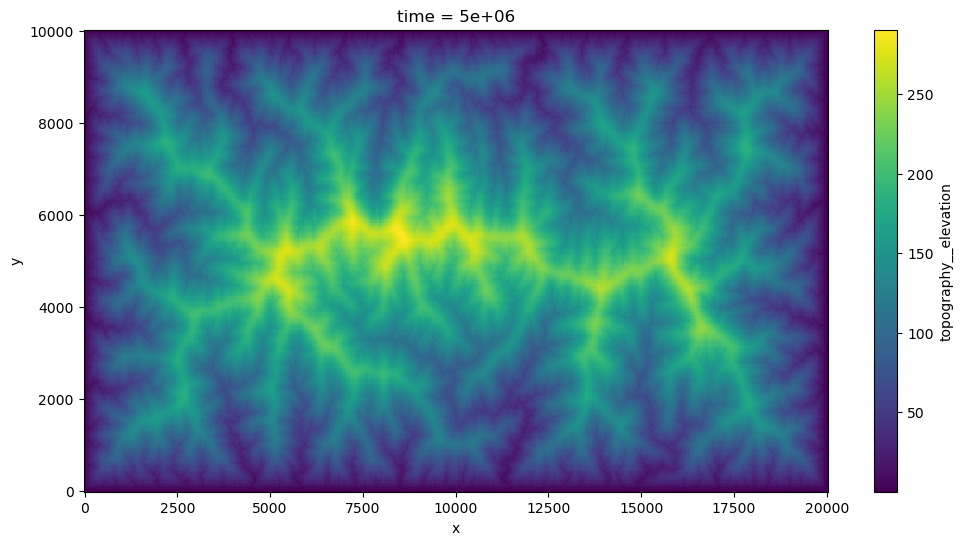

In [7]:
ds_out.topography__elevation.isel(time=-1).plot(size=6, aspect=2);

Fastscape also offers a very nice interactive way of viewing the data TopoViz3D. With this app you can use your mouse to navigate a 3D view of the model. In the app, flip between topography, erosion rate, and drainage area for visualization. If you cannot see something clearly, try rescaling the color bar. Also, I recommend adjusting the vertical exaggeration to factor 10 or so. Let's try it out:

In [8]:
app = TopoViz3d(ds_out, time_dim="time")

app.show()

Output(layout=Layout(height='640px'))

Output(layout=Layout(height='640px'))

Sometimes TopoViz3D is a bit buggy. We can also display the time evolution by just plotting the entire `time` domain and using `col_wrap` to make a nice tiled figure.

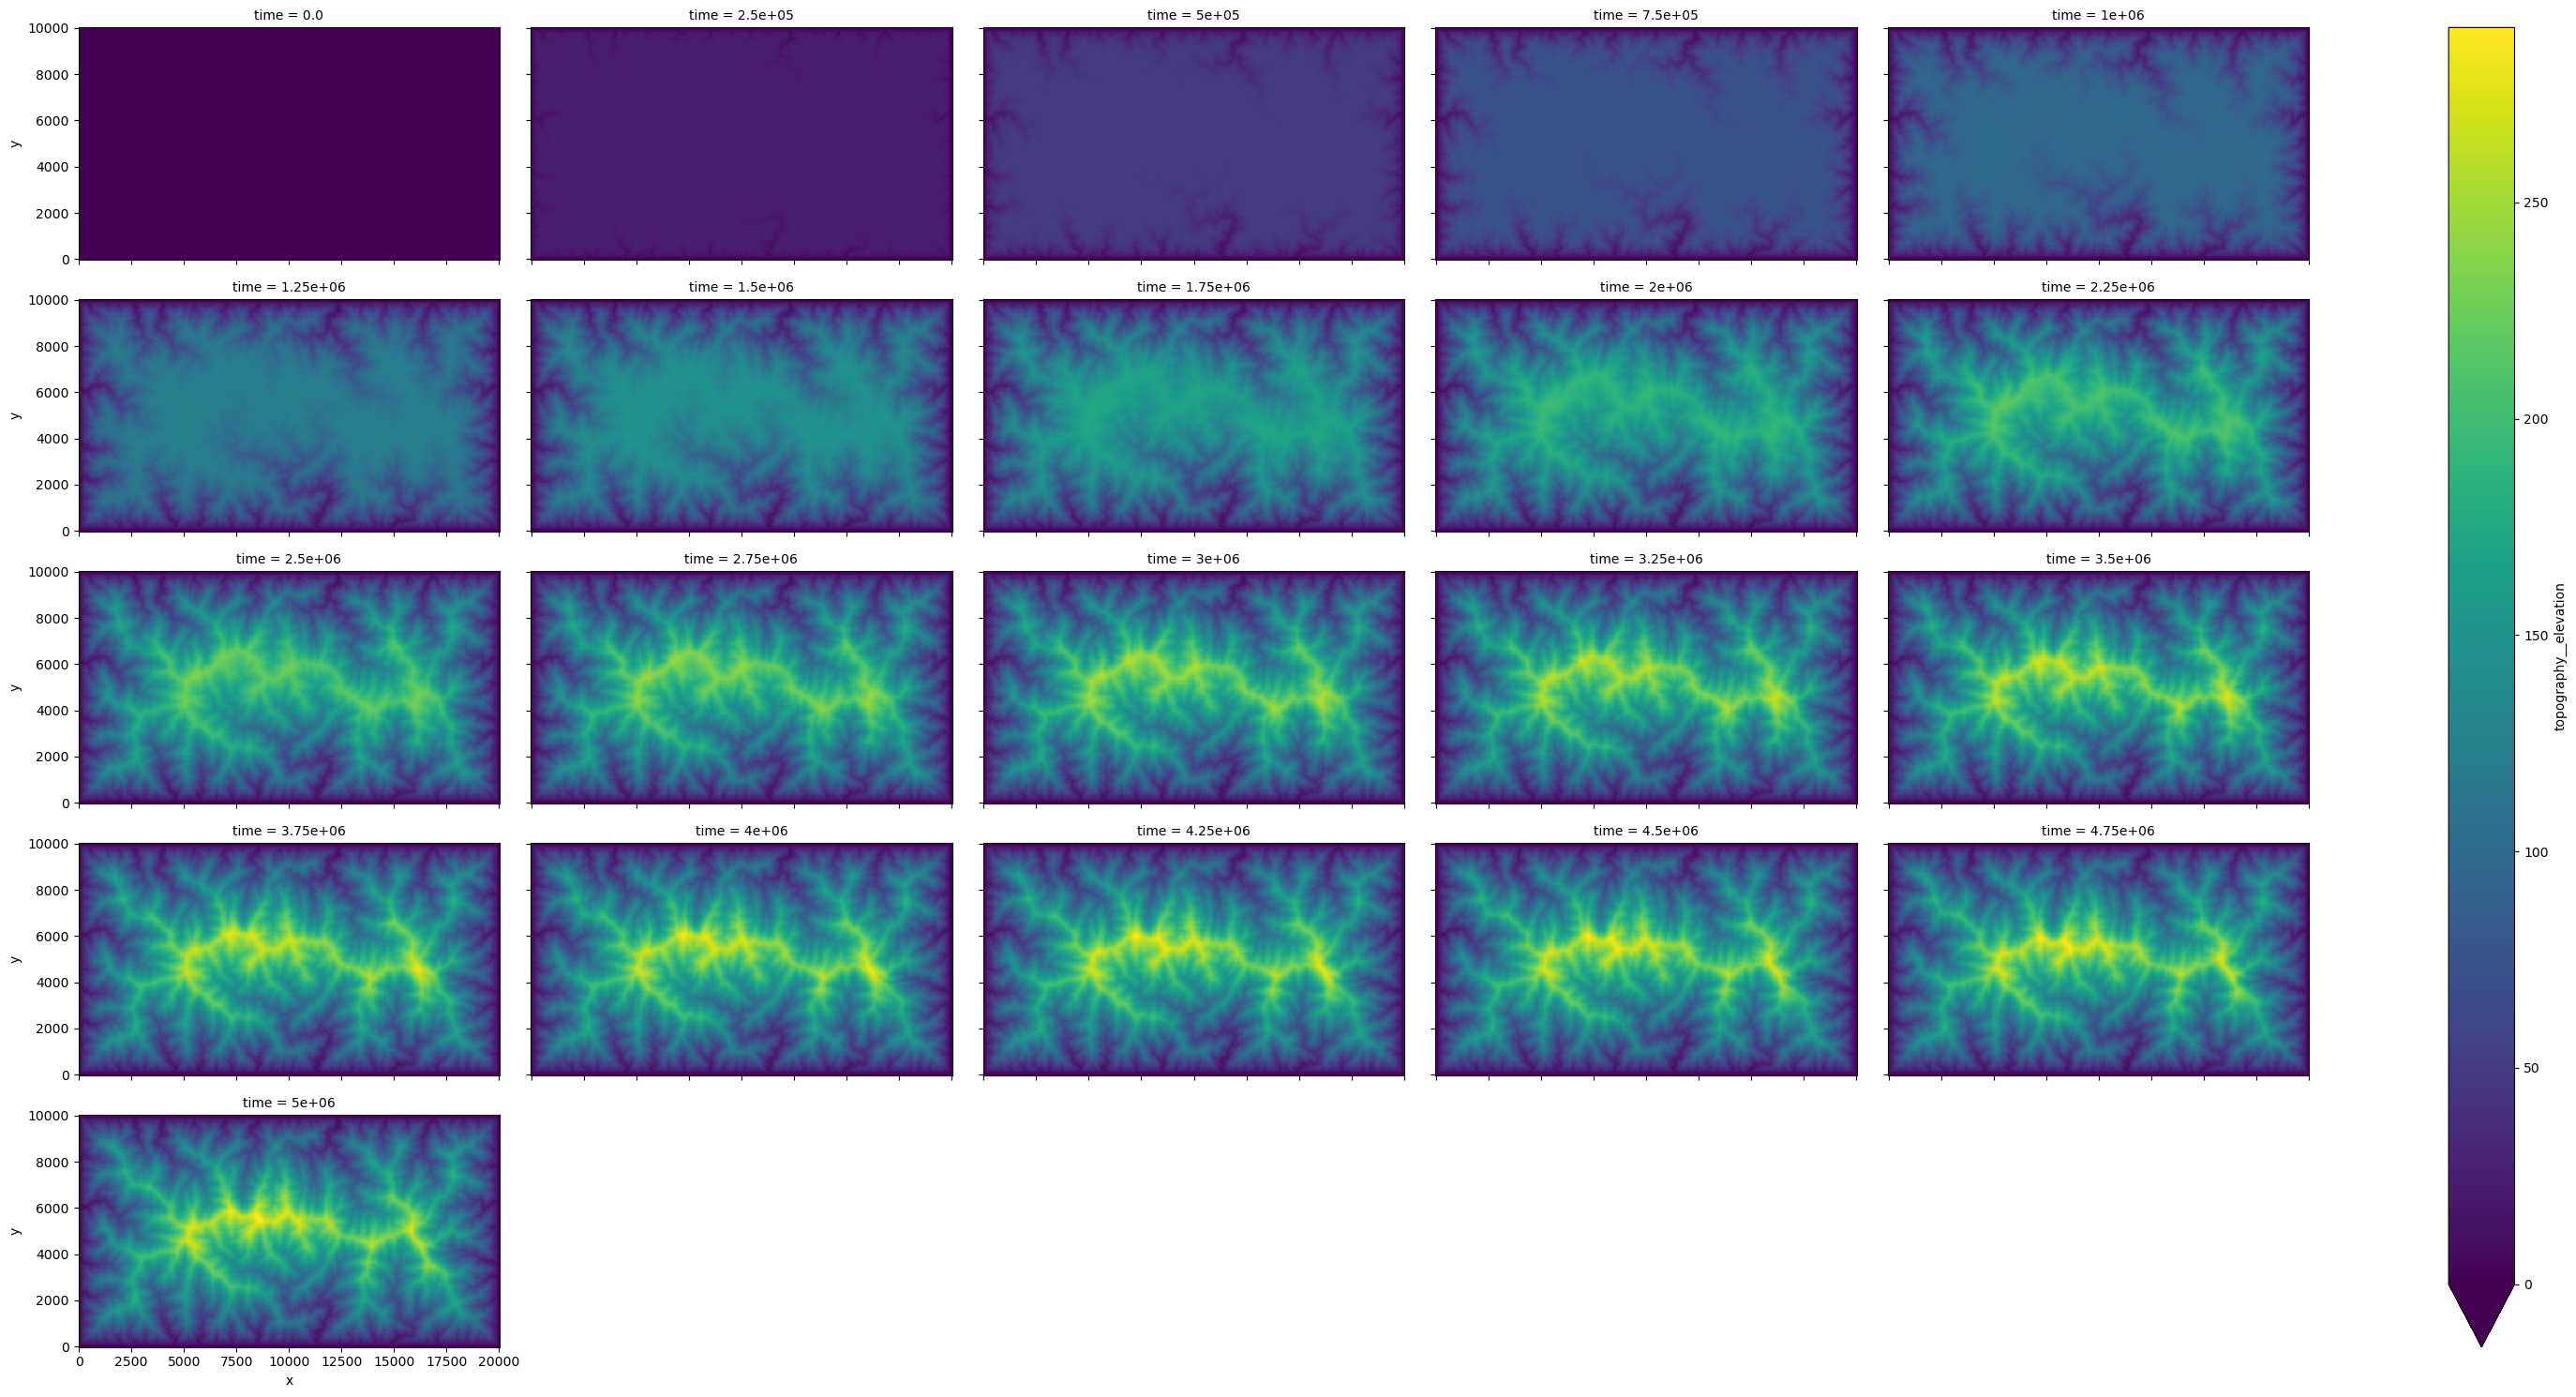

In [10]:
ds_out.topography__elevation.plot(col='time', col_wrap=5, aspect=2, cmap='viridis',vmin = 0);

We can also combine xarray plotting methods with more advanced matplotlib functions such as the creation of multi panel figures using the subplots method. In the following example, we plot in the first panel the evolution of the topography by using the `plot.line()` method, which is used to force multi-line plots from a 2D dataset (here `time` and `x`). Note that you need to specify which of the two dimensions will be plotted along the horizontal 𝑥
 axis. In the second panel, we use the same structure to display erosion rate along the x direction across the model.

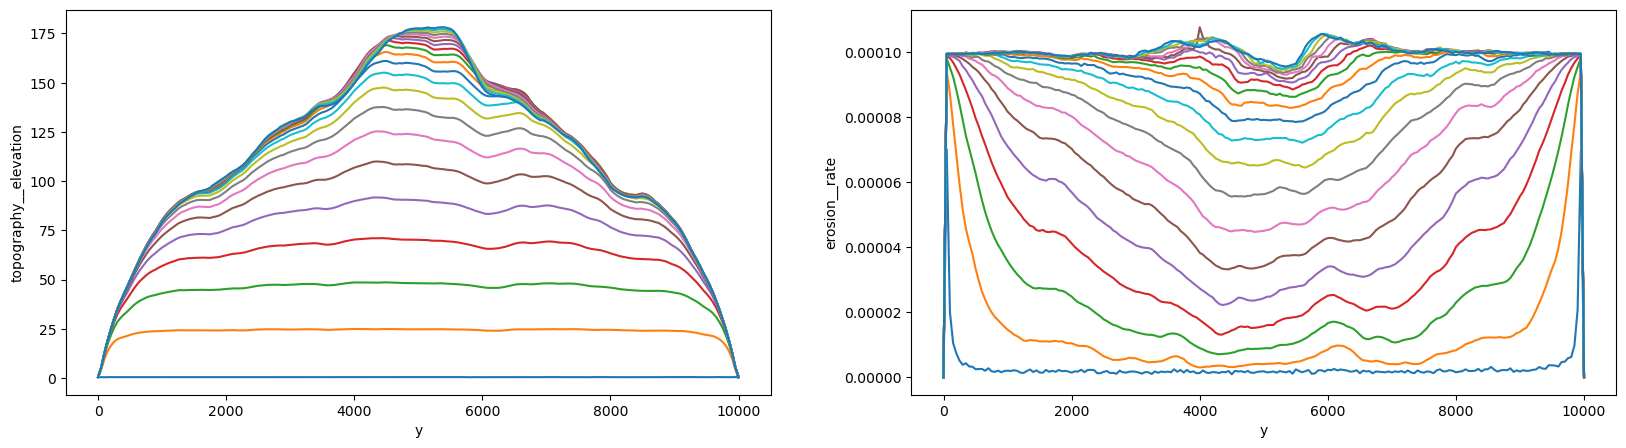

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(20,5))

ds_out.topography__elevation.mean('x').plot.line(ax=ax[0], x='y', add_legend=False)

ds_out.erosion__rate.mean('x').plot.line(ax=ax[1], x='y', add_legend=False)   # display erosion rate here


As you see, the topography approaches a stready state in the final time steps of the model.

**Q2:** How do you interpret the erosion rate plot? Which lines belong to the first time steps and which to the last ones? Why are do many time steps follow a curved shape in terms of erosion rate?


## Changing uplift rate

Now, we have our basic steady-state mountain range. Steady-state meaning topography does not change (topographic steady state) and erosion = uplift rate (flux steady state). Let's change the uplift rate and see what happens. Run a new model. Give it a different name as before and double the uplift rate.

In [12]:
# use same code for setup up model as before and double the uplift rate input. Give your model setup a different name as before, e.g., ds_up2

# use the same code as before to run the model using a with statement. Give your model output a new name such as ds_out2 or similar.


             0% | initialize 

Let's plot a topographic profile across both models and compare them

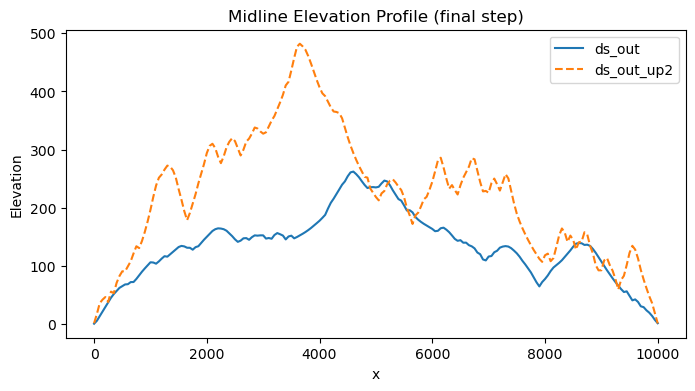

In [13]:
z1 = ds_out.topography__elevation.isel(time=-1)   # use .isel to select last time slice of first model
z2 = # extract elevation from second model with double uplift

# this plots both elevation profiles with the mean function to get the mean elevation along the y dimension
fig, ax = plt.subplots(figsize=(8,4))
x= z1['y'] 
z1_mid = z1.sel(x=z1['y'].mean(), method='nearest')
z2_mid = z2.sel(x=z2['y'].mean(), method='nearest')
ax.plot(x, z1_mid, label='ds_out')
ax.plot(x, z2_mid, label='ds_out_up2', linestyle='--')
ax.set_xlabel('x');ax.set_ylabel('Elevation')
ax.set_title('Midline Elevation Profile (final step)')
ax.legend()
plt.show()

We can use the `.mean()` function and calculate the mean over both x and y dimensions. That allows us to plot the time evolution of topography in both models and compare the final average elevation.

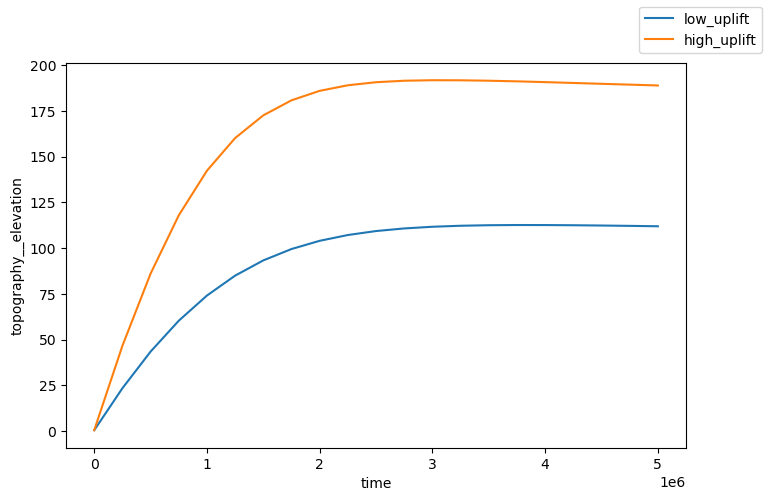

In [14]:
fig, ax = plt.subplots(figsize=(8,5))

ds_out.topography__elevation.mean(('x','y')).plot(ax=ax, label='low_uplift')
# plot mean elevation of high uplift rate model and give it different label

fig.legend()

**Q3:** From this plot, you can estimate the time it takes for the models to reach topographic steady state. How long is that? Now you have a rough idea of how fast a mountain range changes topography.\

**Q4:** Compare the final elevation of the two models. How does the difference between the model run compare to their difference in uplift rate? In other words, how does maximum elevation scale with uplift rate?

## Climate
Ok, we've seen the influence of changing the tectonic uplift rate in our model. Let's see what happens if we change the climate. For that, let's start a new model and let's drop the diffusion process for hillslopes.

In [15]:
from fastscape.processes import FlowAccumulator, MultipleFlowRouter

model = basic_model.drop_processes('diffusion').update_processes({'flow':MultipleFlowRouter, 'drainage':FlowAccumulator})

We create a model that solves the strem power model only (no diffusion) but that allows for a variable precipitation rate (or *runoff*, i.e., proportion of rainfall that is available for erosion). For this, we replace the `drainage` process with a process of type `FlowAccumulator` that not only computes the drainage area but also perform the integral over that area of the runoff to obtain the discharge (`drainage__flowacc`).

We also increase the temporal resolution of the model to capture the temporal evolution better while decreasing the spatial resolution for computational efficiency.

In [16]:
nx,ny = 201,101
xl,yl = 20e3,10e3
x,y = np.meshgrid(np.linspace(0,xl,nx),np.linspace(0,yl,ny))
tf = 5e6
nstep = 1001
nout = 101
tstep = xr.DataArray(np.linspace(0,tf,nstep), dims='tstep')
time = xr.DataArray(np.linspace(0,tf,nout), dims='time')


## Step in rainfall

We first introduce a step (doubling) in the rainfall rate half-way in the evolution of the model

In [17]:
rain = xr.where(tstep<tf/2, 1, 2)  # read this line in detail and try to understand why it works! You can google what .where() does.

In [18]:
# create a new model and use the `rain` variable as input for the the drainage__runoff variable
import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={'time':time,
            'tstep':tstep},
    master_clock='tstep',
    input_vars={
        'grid__shape': [ny,nx],
        'grid__length': [yl,xl],
        'boundary__status': ['looped','looped','fixed_value','core'],
        'uplift__rate': 1e-3,
        'init_topography__seed': None,
        'flow__slope_exp': 1,
        'drainage__runoff': rain,
        'spl__k_coef': 1e-5,
        'spl__area_exp': 0.5,
        'spl__slope_exp': 1,
    },
    output_vars={'topography__elevation':'time',
                 'erosion__rate':'time',
                 'drainage__runoff':'time',
                 'drainage__flowacc':'time'}
)


In [19]:
# run new model

             0% | initialize 

We plot the evolution of the mean topography and sediment flux (mean erosion rate) as a function of time. The dashed line corresponds to the time at which the uplift rate changed. 

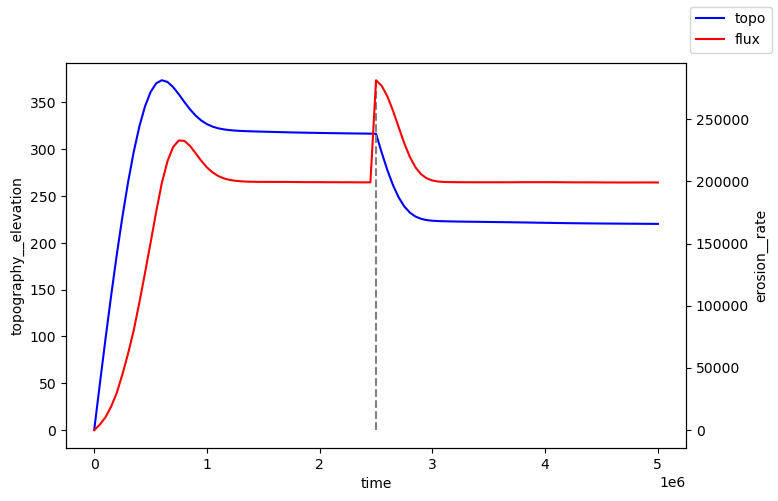

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
# plot mean elevation through time just as before and give it sensible label
ymax = ds_out.topography__elevation.mean(('x','y')).max()
ax.plot([tf/2,tf/2],[0,ymax],'--', c='grey')

# this plots erosional flux through time
ax_flux = ax.twinx()
ds_out.erosion__rate.integrate(('x','y')).plot(ax=ax_flux, label='flux', c='r')

fig.legend()

**Q5:** We see that at the time we impose the step increase in rainfall rate, the system had reached a quasi steady-state. But why does the topography decrease to a new steady state and the erosional flux goes back to the same value as before the change in rainfall rate???


Let's plot the slope change for the same model to illustrate this behavior:

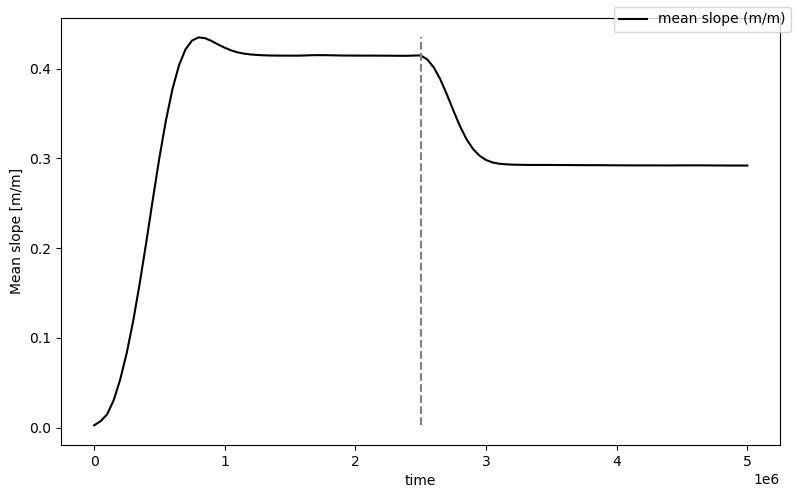

In [26]:
# Compute slope magnitude = sqrt((∂z/∂x)^2 + (∂z/∂y)^2)
Z = ds_out.topography__elevation  # dims: time, y, x (typ.)
dzdx = Z.differentiate('x')       # uses x coords for spacing
dzdy = Z.differentiate('y')       # uses y coords for spacing
slope = np.hypot(dzdx, dzdy)      # m/m
mean_slope = slope.mean(('x','y'))

fig, ax = plt.subplots(figsize=(8,5))
mean_slope.plot(ax=ax, c='k', label='mean slope (m/m)')

# vertical marker at tf/2
ymin = float(mean_slope.min())
ymax = float(mean_slope.max())
ax.plot([tf/2, tf/2], [ymin, ymax], '--', c='grey')

ax.set_xlabel('time')
ax.set_ylabel('Mean slope [m/m]')
fig.legend(loc='upper right')
plt.tight_layout()
plt.show()


## Step in uplift rate

We now impose a doubling in uplift rate half-way through the model run. Instead of re-defining the whole model, we can also use the  `xsimlab.update_vars()` command to enter our new uplift rate.

In [21]:
uplift = xr.where(tstep<tf/2, 1e-3, 2e-3)

with model, xs.monitoring.ProgressBar():
    ds_out_u = (ds_in
                .xsimlab.update_vars(input_vars={'uplift__rate': uplift, 'drainage__runoff': 1})
                .xsimlab.run())

             0% | initialize 

Let's plot the evolution of elevation, erosion flux, and slope:

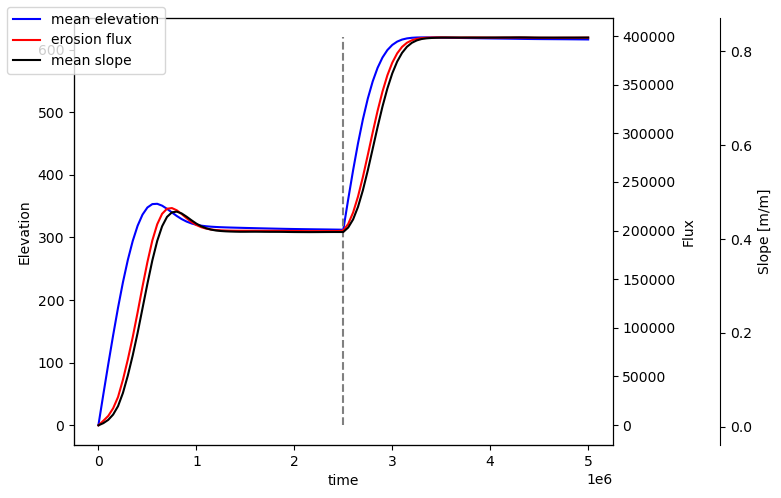

In [22]:
fig, ax = plt.subplots(figsize=(8,5))

# Left axis: mean elevation
mean_z = ds_out_u.topography__elevation.mean(("x","y"))
mean_z.plot(ax=ax, label="mean elevation", c="b")
ymax = float(mean_z.max())
ax.plot([tf/2, tf/2], [0, ymax], "--", c="grey")
ax.set_ylabel("Elevation")

# Right axis #1: total erosion flux (space-integrated)
ax_flux = ax.twinx()
# If your xarray version doesn't accept a tuple in integrate, do: .integrate("x").integrate("y")
flux = ds_out_u.erosion__rate.integrate(("x","y"))
# flux = ds_out_u.erosion__rate.integrate("x").integrate("y")  # fallback
flux.plot(ax=ax_flux, label="erosion flux", c="r")
ax_flux.set_ylabel("Flux")

# Right axis #2 (offset): mean slope magnitude
Z = ds_out_u.topography__elevation  # dims ('time','y','x')
dzdx = Z.differentiate("x")
dzdy = Z.differentiate("y")
mean_slope = np.hypot(dzdx, dzdy).mean(("x","y"))

ax_slope = ax.twinx()
ax_slope.spines["right"].set_position(("axes", 1.20))  # push outward so it doesn’t overlap ax_flux
mean_slope.plot(ax=ax_slope, label="mean slope", c="k")
ax_slope.set_ylabel("Slope [m/m]")

# One combined legend
lines, labels = [], []
for a in (ax, ax_flux, ax_slope):
    L = a.get_legend_handles_labels()
    lines += L[0]; labels += L[1]
fig.legend(lines, labels, loc="upper left")

plt.tight_layout()
plt.show()


**Q6:** What is the response to of the landscape to doubling the uplift rate? \

## Bedrock erodbility

Bedrock erodibility varies by several orders of magnitude across Earth's surface. See here for instance the relative erodbilities of rock types from erosion mill experiments:
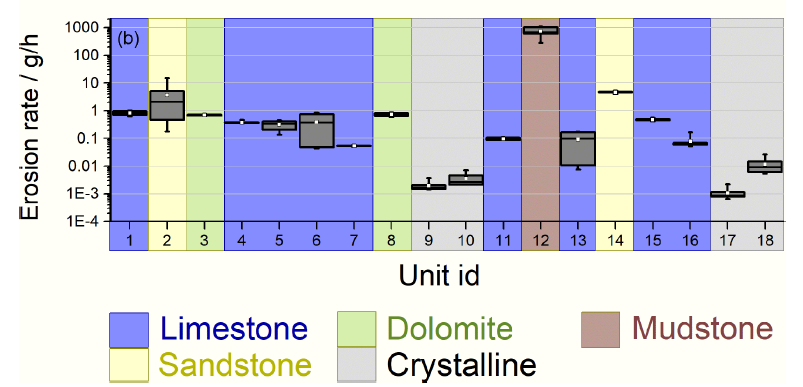
Erosion rates from experiments show large differences between rock types for the same amount of simulated fluvial impact erosion (Turowski et al., 2023). This implies large differences in erodbility (the susceptibility of rock to erosion and weathering).

But what is the effect of this on mountains and their steepness?

In fastscape erodbility is stored as `spl__k_coef`. Meaning the Stream Power Law—you'll learn in the next lesson what that is. For now, it's enough to know that this is the standard physical law to model river ersion—erodbility coefficient. As before with uplift rate, use the `xsimlab.update_vars` function to update this variable to double the original value.

**Q7:** What does doubling `K` mean? Are you know simulating weaker of harder rock? Do you expect the mountains to be smaller or bigger than in the previous simulation?


In [23]:
# use with statement to run model and use update_vars to double K just as we've seen before

             0% | initialize 

Plot the elevation and slope through time again. How did it change?

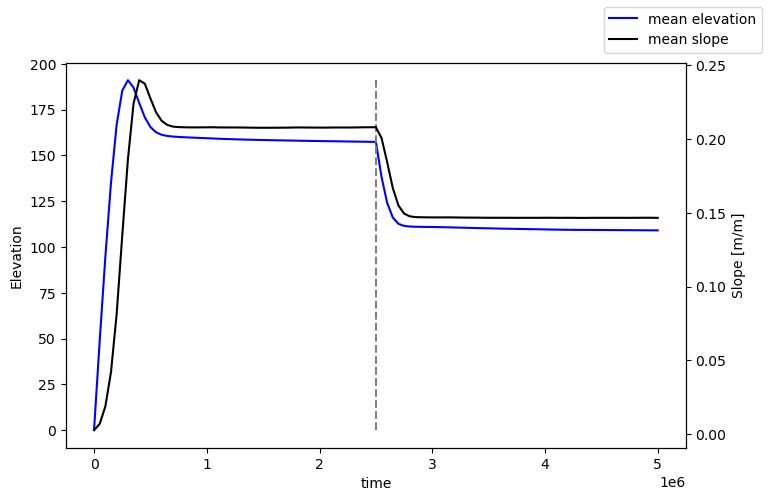

In [24]:
fig, ax = plt.subplots(figsize=(8,5))

# Left axis: mean elevation
mean_z = ds_out_k.topography__elevation.mean(("x","y"))
mean_z.plot(ax=ax, label="mean elevation", c="b")
ymax = float(mean_z.max())
ax.plot([tf/2, tf/2], [0, ymax], "--", c="grey")
ax.set_ylabel("Elevation")

# Right axis 1: slope
ax_slope = ax.twinx()
Z = ds_out_k.topography__elevation  # dims ('time','y','x')
dzdx = Z.differentiate("x")
dzdy = Z.differentiate("y")
mean_slope = np.hypot(dzdx, dzdy).mean(("x","y"))
mean_slope.plot(ax=ax_slope, label="mean slope", c="k")
ax_slope.set_ylabel("Slope [m/m]")

fig.legend()
plt.show()


**Q8:** How did doubling K change the elevation and slope of the mountain range?

## Source to sink
As we've learned, sediments generated from erosion in mountains move through the landscape towards intermittent and final sinks. So far, we've only modelled an erosional landscape; mountain ranges are usually dominated by erosion with only minor long-term sediment deposition. However, Fastscape can also model sediment deposition and thus a full source to sink system.
Let's model a mountain range that is actively uplifting along with its foreland (the lowland area in front of a mountain range).

For that we first need to import the sediment model. Again, we'll drop the diffusion process for hillslopes to make the models simpler and faster to run.

In [2]:
from fastscape.models import sediment_model

model = sediment_model.drop_processes('diffusion')

We create a setup made of a 200 km long and 100 km wide strip that contains a mountain belt (uplifting region) and an alluvial plain (no uplift region). The base level is imposed at the end of the alluvial plain, while the opposite side is set as a reflective boundary condition, representing an imposed drainage divide. The other side boundaries are cyclic.

In [3]:
nx,ny = 201,101
xl,yl = 200e3, 100e3
tf = 10e6
nstep = 101
nout = 101
tstep = xr.DataArray(np.linspace(0,tf,nstep), dims='tstep')
time = xr.DataArray(np.linspace(0,tf,nout), dims='time')
x,y = np.meshgrid(np.linspace(0,xl,nx), np.linspace(0,yl,ny))
x = xr.DataArray(x, dims=('y','x'))
y = xr.DataArray(y, dims=('y','x'))
xmountain = 150e3
uplift = xr.where(x>xmountain, 1e-3, 0)

In [4]:
# %create_setup model
import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={'time':time, 'tstep':tstep},
    master_clock='tstep',
    input_vars={
        'grid__shape': [ny,nx],
        'grid__length': [yl,xl],
        'boundary__status': ['fixed_value','core','looped','looped'],
        'uplift__rate': uplift,
        'init_topography__seed': None,
        'flow__slope_exp': 1,
        'spl__area_exp': 0.45,
        'spl__slope_exp': 1,
        'spl__k_coef_bedrock': 1e-5,
        'spl__k_coef_soil': 1e-5,
        'spl__g_coef_bedrock': 1,
        'spl__g_coef_soil': 1,
    },
    output_vars={'topography__elevation':'time',
                 'erosion__rate':'time',
                 'drainage__area':'time'
                 }
)

In [5]:
# run model

             0% | initialize 

Let's plot the topographic profile of the model in the same manner as we did before. Use `[::10]` when assigning the time steps to plot, to make sure that only every tenth time step is plotted.

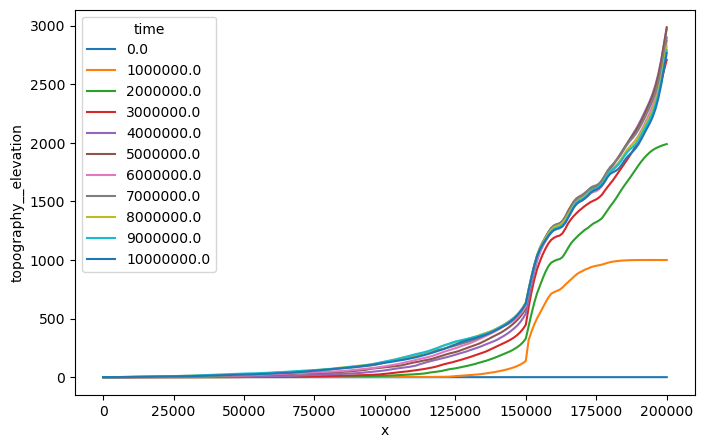

In [6]:
fig, ax = plt.subplots(figsize=(8,5))

# plot topographic profile as the mean of the y-dimension

Let's look at the 3D topography again with the TopoViz3d app. In the app, flip between topography, erosion rate, and drainage area for visualization. If you cannot see something clearly, try rescaling the color bar.

In [7]:
# display 3D data with TopoViz3D

Output(layout=Layout(height='640px'))

Let's compare the sediment flux out of the model, with what gets eroded in the mountains. For that we can use the `.integrate()` function and add up all the erosion.

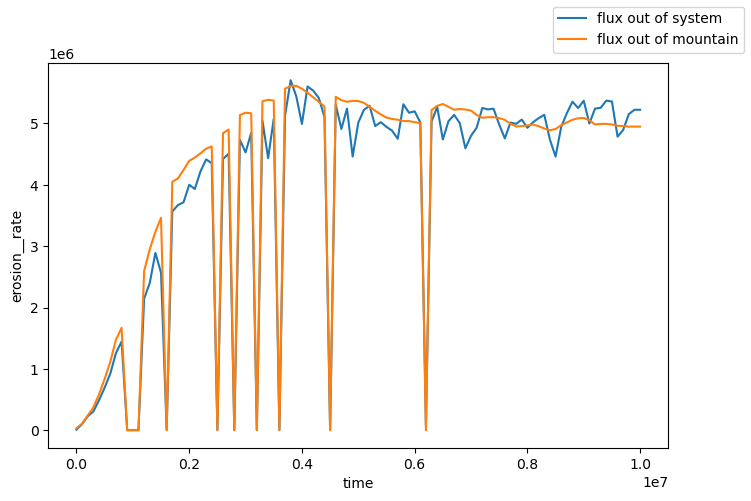

In [8]:
fig, ax = plt.subplots(figsize=(8,5))

ds_out.erosion__rate.integrate(('x','y')).plot(ax=ax, label='flux out of system')
ds_out.erosion__rate.where(x>xmountain).dropna('x').integrate(('x','y')).plot(ax=ax, label='flux out of mountain')
fig.legend();

If we look at the sediment flux out of the mountain and out of the alluvial plain, they follow a very similar temporal pattern with only a slight delay between the two. This means the alluvial plain mostly bypasses sediment. The rivers in the plain have adjusted their slope to the amount of eroded material from the mountains, and what goes out of the model equals what erodes from the mountains. 

**Q9:** Why is the flux out of the mountains a bit higher than the sediment flux out of the system during the time before steady-state? 

Note there might be some weird model artefacts in the flux data with the flux briefly going to zero at certain time steps. Not sure why. Focus on the general pattern.